## Importing Packages

In [1]:
# Libraries for wranggling the data
import numpy as np
import pandas as pd

# Libraries for visualizing our data
import seaborn as sns
import matplotlib.pyplot as plt

# Libraries for operating algorithim
from surprise import SVD, Reader, Dataset
from surprise.model_selection import GridSearchCV, cross_validate

# Library fopr tracking runtime
from time import time
from datetime import datetime

# Library for removing error messages
import warnings
warnings.filterwarnings('ignore')

## Loading the Data

### Within Kaggle

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/alx-movie-recommendation-project-2024/sample_submission.csv
/kaggle/input/alx-movie-recommendation-project-2024/movies.csv
/kaggle/input/alx-movie-recommendation-project-2024/imdb_data.csv
/kaggle/input/alx-movie-recommendation-project-2024/genome_tags.csv
/kaggle/input/alx-movie-recommendation-project-2024/genome_scores.csv
/kaggle/input/alx-movie-recommendation-project-2024/train.csv
/kaggle/input/alx-movie-recommendation-project-2024/test.csv
/kaggle/input/alx-movie-recommendation-project-2024/tags.csv
/kaggle/input/alx-movie-recommendation-project-2024/links.csv


### Brief description of the data



In [3]:
# load the data
train = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/train.csv')
test = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/test.csv')

In [4]:
# Preview train dataset
print(f'The Shape of the data is: {train.shape}')
train.head()

The Shape of the data is: (10000038, 4)


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [5]:
# Preview test dataset
print('The Shape of the data is: ', test.shape)
test.head()

The Shape of the data is:  (5000019, 2)


,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


## Exploratory Data Analysis (EDA)


### Train and Test Data
We can start with the most important datasets which are the train and test datasets.
Let us check for outliers, null values and column types.

In [6]:
# checking for null values
print(f'''Train data:\n{train.isnull().sum()}''')
print(f'''\nnTest data:\n{test.isnull().sum()}''')

Train data:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

nTest data:
userId     0
movieId    0
dtype: int64


In [7]:
# train column dtype check
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


In [8]:
# test column dtype check
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


In [9]:
# checking for unique values
print(f'''Train data:\n{train.nunique()}''')
print(f'''\n\nTest data:\n{test.nunique()}''')

Train data:
userId        162541
movieId        48213
rating            10
timestamp    8795101
dtype: int64


Test data:
userId     162350
movieId     39643
dtype: int64


visualizing the ratings to observe the distributions.

In [10]:
# group by ratings for visualization
ratings_df = train.groupby(['rating']).count()

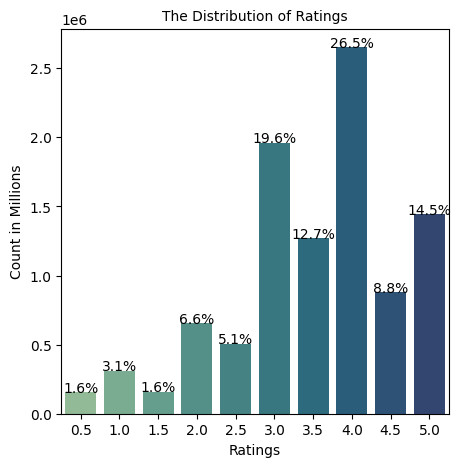

In [11]:
#Plot showing the distribution of counts
plot = plt.figure(figsize=(5, 5))
a = sns.barplot(x=ratings_df.index,y='userId',data=ratings_df,palette='crest')
a.set_title('The Distribution of Ratings',fontsize=10)
a.set_ylabel('Count in Millions',fontsize=10)
a.set_xlabel('Ratings',fontsize=10)

#Obtaining percentages on top of bars
n_obs = [i.get_height() for i in a.patches]
total = sum(n_obs)

for i in a.patches:
    # get_x pulls left or right; get_height pushes up or down
    a.text(i.get_x()+i.get_width() / 2, i.get_height()+0.5, \
            str(round((i.get_height()/total)*100, 1))+'%', fontsize=10,
                color='black',ha='center')

plt.show()


From the above cells we can conclude that:
- There are no outliers especially on the train rating column.
- There are no null values in the two data sets.
- All the columns are numerical type.
- Higher ratings were given on average with `4` given the most times with a percentage of `26.5%`.

## Data Engineering

In [12]:
# Showing the number of unique users
train['userId'].nunique()

162541

In [13]:
# Showing the number of unique users
test['userId'].nunique()

162350

Checking if there are any userIds that are in the test data and not in the train data.

In [14]:
test_case = test['userId'].unique()
train_case = train['userId'].unique()
print([id for id in test_case if id not in train_case])

[]


#### Sorting of Tables

In [15]:
# Sort train dataset by userId
train.sort_values(by=['userId'], inplace= True)
train.head()

,userId,movieId,rating,timestamp
6308822,1,296,5.0,1147880044
3137042,1,27721,3.0,1147869115
2533005,1,665,5.0,1147878820
2524478,1,4308,3.0,1147868534
1946297,1,1250,4.0,1147868414


In [16]:
train.shape

(10000038, 4)

In [17]:
# Sort test dataset by userId
test.sort_values(by=['userId'], inplace= True)
test.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [21]:
test.shape

(5000019, 2)

## Modelling

### Collaborative filtering

These are recommender systems that are base solely on the past interations recorded between users and items, in our case userIds and movies. These interactions are stored in **user-item interaction matrix**.

The main idea that rules collaborative method is that the past user-item interations are sufficient to detect similar users and/or similar items that make predictions possible.

Consdering the above, in our EDA above, we confirmed that all userIds in the test dataset are present in the train dataset, we also confirmed that all movieIds in the test dataset are also present in the train dataset. Hence we can proceed to make prediction(movie ratings) using the **Collaborative filtering method**

#### Drop unwanted columns

In [18]:
# Drop key_words column for the train dataset
ratings = train.drop(columns='timestamp')

# Instanciate a Reader object from surprise package
reader = Reader()

# Instanciate the dataset object from surprice package with the ratings table and reader object
data = Dataset.load_from_df(ratings, reader)

### Instanciate and train an SVD model from the surprise package

#### Hyperparameter Tuning with GridSearchCV

In [19]:
# Setting global constants to ensure notebook results are reproducible
RANDOM_STATE = 25

# Parameter combinations to search through
param_grid = {'n_epochs':[40],
              'n_factors':[1800, 2000],
              'init_std_dev':[0.005],
              'random_state':[RANDOM_STATE]}

grid_SVD = GridSearchCV(SVD, cv=2, measures=['rmse'], param_grid=param_grid, n_jobs=-1, joblib_verbose=10)
grid_SVD.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 46.7min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed: 46.9min remaining: 46.9min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 51.1min finished


In [20]:
# Show best parameter score
print('Best Score is: ')
print(grid_SVD.best_score['rmse'])

# Show best parameters
print('Best Parameters are: ')
print(grid_SVD.best_params['rmse'])

Best Score is: 
0.8205026411684151
Best Parameters are: 
{'n_epochs': 40, 'n_factors': 1800, 'init_std_dev': 0.005, 'random_state': 25}


In [23]:
start_time = time()

# Instantiate an SVD model from the surprise package
svd = SVD(n_epochs=40,n_factors=1800,init_std_dev=0.005,random_state=RANDOM_STATE,verbose=True)

# Instanciate and build the dataset with data object from surprise package
trainset = data.build_full_trainset()

# Train the SVD model
svd.fit(trainset)

end_time = time()
time_seconds = end_time - start_time
time_minutes = round(time_seconds / 60, 1)
print(f"Time taken to build trainset: {time_minutes}min")

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Time taken to build trainset: 53.8min


## Making Predicitons


In [24]:
# Extract the userIds and corresponding movieIds into a python list
userId = test['userId'].values.tolist()
movieId = test['movieId'].values.tolist()

# Create a range of numbers which is the size of list created above
count = len(userId)
rating = []
ids = []

# Make rating predictions with the corresponding userIds and movieIds, accessed through indexing
for i in range(count):
    result = svd.predict(userId[i], movieId[i])[3]

    # Store the predicted rating
    rating.append(result)

    # Prepare, save userId and movieId for submission
    ids.append(str(userId[i]) + '_' + str(movieId[i]))

In [25]:
# Store data needed for dataframe
data = {'Id': ids, 'rating': rating}

In [26]:
# Create the dataframe
test_sub_df =  pd.DataFrame(data)
test_sub_df.head()

,Id,rating
0,1_2011,3.195840
1,1_4144,4.229688
2,1_5767,3.719302
3,1_6711,4.025117
4,1_7318,2.890713


In [27]:
# Confirming dataframe shape
test_sub_df.shape

(5000019, 2)

In [28]:
# Convert dataframe to csv file for submission.
test_sub_df.to_csv('Kaggle_submission.csv', index=False)